# 数据预处理

In [3]:
import pandas as pd
from tqdm import tqdm
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import json
import os

# 工作路径改为/quoraDupli
os.chdir(os.path.dirname(os.getcwd()))
print os.getcwd()

/software/home/chenzh/software/jupyter/quoraDupli


In [3]:
# 数据载入
def dataLoad(path=os.path.join('data', 'quora_duplicate_questions.tsv')):
    df = pd.read_csv(path, delimiter='\t')
    df = df.dropna(how='any')  # 删除两行缺失数据
    # 转换编码
    df['question1'] = df['question1'].apply(lambda x: unicode(str(x), 'utf-8'))
    df['question2'] = df['question2'].apply(lambda x: unicode(str(x), 'utf-8'))
    
    stats(df)
    
    return df

# 统计数据信息
def stats(df):
    print '数据量: %d行' % (df.shape[0])
    rowNum0 = df['is_duplicate'].value_counts()[0]
    rowNum1 = df['is_duplicate'].value_counts()[1]
    print '重复: 不重复 = %d : %d = 1 : %f' \
          % (rowNum1, rowNum0, (rowNum0 * 1.0 / rowNum1))
    uniqueId = set(list(df['qid2'].unique()) + list(df['qid1'].unique()))
    print '问题总数: %d' % (len(uniqueId))

# 绘图
def drawing(df):
    counter = Counter([len(x.split()) for x in df['question1'] + df['question2']])
    labels = ['0-9', '10-19', '20-29', '30-39', '>=40']
    sizes = [0, 0, 0, 0, 0]
    for k, v in counter.items():
        if 0 <= k < 10:
            sizes[0] += v
        elif 10 <= k < 20:
            sizes[1] += v
        elif 20 <= k < 30:
            sizes[2] += v
        elif 30 <= k < 40:
            sizes[3] += v
        else:
            sizes[4] += v
    plt.pie(sizes, labels=labels, explode=(0.05, 0, 0, 0.05, 0.05),
            autopct='%2.2f%%', pctdistance=0.8)
    plt.axis('equal')
    plt.legend(loc='upper right')
    plt.show()

# 计算TF-IDF分数
# 返回dict={'word':tfidfScore}
def getTfIdfScore(df):
    from sklearn.feature_extraction.text import TfidfVectorizer

    questions = list(df['question1']) + list(df['question2'])

    tfIdf = TfidfVectorizer(lowercase=False)
    tfIdf.fit_transform(questions)

    word2tfIdf = dict(zip(tfIdf.get_feature_names(), tfIdf.idf_))
    return word2tfIdf

数据量: 404288行
重复: 不重复 = 149263 : 255025 = 1 : 1.708561
问题总数: 537931


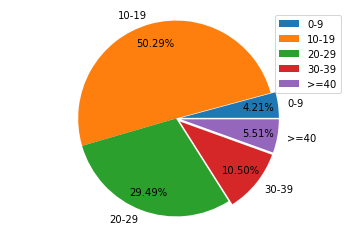

In [4]:
data = dataLoad()
drawing(data)
    
with open(os.path.join('data', 'tfIdfScore.json'), 'w') as fp:
    fp.write(json.dumps(getTfIdfScore(data)))

# w2v

导入spaCy模型数据，将每个词转化为300维的向量

In [7]:
# 数据载入
df = dataLoad()
if os.path.exists(os.path.join('data', 'tfIdfScore.json')):
    with open(os.path.join('data', 'tfIdfScore.json'), 'r') as fp:
        tfIdfScore = json.loads(fp.read())
else:
    print '载入tfIdfScore.json失败'
    tfIdfScore = getTfIdfScore(df)

import en_core_web_md as md

nlp = md.load()
questionList = [list(df['question1']), list(df['question2'])]
finalVec = []
for i, questions in enumerate(questionList):
    print '正在处理question%i......' % (i+1)
    vec = []
    for question in tqdm(questions):
        words = nlp(question)
        mean_vec = np.zeros([len(words), 300])
        for word in words:
            wordVector = word.vector
            try:
                idf = tfIdfScore[str(word)]
            except:
                idf = 0
            mean_vec += wordVector * idf
        mean_vec = mean_vec.mean(axis=0)
        vec.append(mean_vec)
    finalVec.append(vec)

df['q1Vector'] = finalVec[0]
df['q2Vector'] = finalVec[1]

# 保存，方便下次调用
pd.to_pickle(df, os.path.join('data', 'questionVector.pickle'))

数据量: 404288行
重复: 不重复 = 149263 : 255025 = 1 : 1.708561
问题总数: 537931


  0%|          | 20/404288 [00:00<33:46, 199.47it/s]

正在处理question1......


  0%|          | 76/404288 [00:00<09:02, 744.90it/s]

正在处理question2......


100%|██████████| 404288/404288 [09:39<00:00, 698.25it/s]


In [4]:
path=os.path.join('data', 'quora_duplicate_questions.tsv')
df = pd.read_csv(path, delimiter='\t')
df


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0
